# Simple Bayesian Statistical Analysis & Gaussian Naive Bayes Classifier (pymc Method)



## 1. Simple Bayesian Statistical Analysis
For this problem you will perform a simple Bayesian statistical analysis with `pymc`.  

### 1.1. Normal simulation & histogram
Simulate $N=200$ observations from a $\mathcal{N}(\mu=5,\sigma=2)$ distribution. Report the mean and standard deviation, and plot a histogram of the simulated data. 


sample mean = 5.006650718566106
sample std = 1.9110889360464596


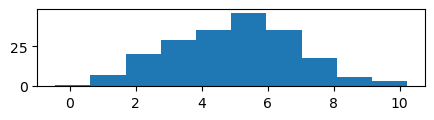

In [1]:
import numpy as np
N=200; 
rng = np.random.default_rng(seed=12345)
X = rng.normal(loc=5.0, scale=2.0, size=N)

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 1)); plt.hist(X);
print( f"sample mean = {X.mean()}")
print( f"sample std = {X.std()}")

### 1.2. Hierarchical model with simulated data & graph

Now, assume you don't know the values of the parameters ($\mu,\sigma$), but want to estimate them with a hierarchical model. Specify the following model in `pymc`:
    $$\text{priors: }M \sim \mathrm{Normal}( \mu = 0, \sigma = 100 ), \quad S \sim \mathrm{InverseGamma}( \alpha = 0.001, \beta = 0.001 ) $$
    $$\text{likelihood: } X_i \sim^{iid} \mathrm{Normal}( \mu = M, \sigma = S ),\;\; \forall i=1,\ldots,N $$
    Use the data you simulated as observed values in the model, and plot the model's graph.

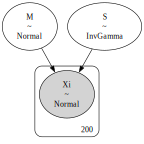

In [2]:
import numpy as np
N=200;rng = np.random.default_rng(seed=12345)
X = rng.normal(loc=5.0, scale=2.0, size=N)

import pymc as pm; from pymc import Model
with Model() as my_model:  
    M = pm.Normal("M", mu = 0, sigma = 100) 
    S = pm.InverseGamma("S", alpha = 0.001, beta = 0.001) 
    Xi = pm.Normal("Xi", mu = M, sigma = S, observed = X )
# import graphviz;import matplotlib as plt
graph = pm.model_to_graphviz(my_model);graph.graph_attr.update(size='8,2');graph

### 1.3. Posterior Sample & Posterior Distribution Plot

Use `pymc.sample()` to draw a posterior sample from the model, and plot it using `pymc.plot_posterior()`. 

Compare the posterior to the true values of the parameters:
As shown in the plot, the posterior distributions are centered around the true values of the parameters, and their 95% HDI contains the true values. If we had conditioned on mode observed values of X, the posterior densities would be even more concentrated around the true values.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, S]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': 'M'}>, <Axes: title={'center': 'S'}>],
      dtype=object)

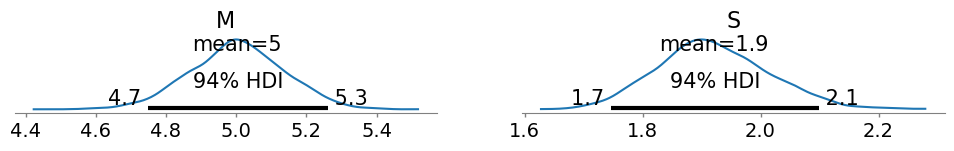

In [3]:
import pymc as pm; from pymc import Model

post_sample = pm.sample(model=my_model)
pm.plot_posterior(post_sample, figsize=(12, 1)) 

### 1.4. Maximize A Posterior Probability (MAP) Estimates

Note: Another approach to Baysian inference is to find the values of the (random) parameters that maximize their posterior density/probability; also known as [maximum-a-posteriori (MAP)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) estimation. The function `pymc.find_MAP()` finds the MAP estimates of the unobserved variables in the model. As shown in below, the MAP estimates are very close to the true values of the parameters.

In [4]:
import pymc as pm; from pymc import Model

MAP = pm.find_MAP( model = my_model )
print(MAP)


{'M': array(5.00664108), 'S_log__': array(0.64517774), 'S': array(1.90632583)}


# 2. Gaussian Naive Bayes Classifier
## 2.1. Fit & Predict use sklearn
Implement a Gaussian Naive Bayes classifier in `pymc`.
    
    a. Using the WDBC data, fit a Naive Bayes classifier with `sklearn.naive_bayes.GaussianNB()`on just two features: `'radius_m'` and `'fractal_dimension_m'`.
    Fit the model on the training data defined below, and save the test data preditions.


In [5]:
import pandas as pd;import numpy as np

from sklearn.datasets import load_breast_cancer
tmp = load_breast_cancer() # load dictinary of 'target' (y) and 'data' (X)  variables
wdbc = pd.DataFrame( data= np.c_[ tmp['target'], tmp['data'] ], # make pandas DataFrame
        columns= ['diagnosis', 'radius_m', 'texture_m', 'perimeter_m','area_m', 'smoothness_m', 'compactness_m', 
        'concavity_m','concave_points_m', 'symmetry_m', 'fractal_dimension_m','radius_se', 'texture_se', 'perimeter_se', 
        'area_se', 'smoothness_se','compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
        'fractal_dimension_se', 'radius_w', 'texture_w','perimeter_w', 'area_w', 'smoothness_w','compactness_w', 
        'concavity_w', 'concave_points_w','symmetry_w', 'fractal_dimension_w'])
X = wdbc[ ['radius_m','fractal_dimension_m'] ].to_numpy()
y = wdbc['diagnosis'].to_numpy() # numerical (0/1) binary variable, diagnosis = 0.0 -> malignant; 1.0 -> benign; 

In [6]:
### Train Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state = 12345, test_size=0.20 )

### Naive Bayes classifier & model fit & predictions 
from sklearn.naive_bayes import GaussianNB 
clf_GNB = GaussianNB().fit( X_train, y_train)
y_pred_GNB = clf_GNB.predict(X_test)

## 2.2. pymc method
The following code creates a probabilistic model for the GNB classifier. 
$$ Y\sim \text{Bernoulli}(p),\; X_i|Y \sim  \begin{cases} 
\text{Normal} ( \mu_{i,0}, \sigma_{i,0}), & Y=0 \\ 
\text{Normal} ( \mu_{i,1}, \sigma_{i,1}), & Y=1 \\
\end{cases}, \;\; \forall i=1,\ldots,D$$

Note the use of the `pymc.NormalMixture()` function to implement the conditional feature distribution as a discrete mixture of two Normals, with 0-1 mixing weights defined by $Y$ (i.e., when $Y=0$, the weight ($1-Y$) for $\text{Normal}(\mu_{i,0},\sigma_{i,0})$ is 1, and when $Y=1$, the weight ($Y$) for $\text{Normal}(\mu_{i,1},\sigma_{i,1})$ is 1).
Also note the use of the `pm.Data(mutable=True)` or `pm.MutableData()` to specify *mutable* observed features for the model, which can be changed without the need to re-define the model. This will come handy when we want to make out-of-sample predictions from the model. 

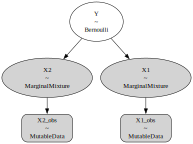

In [7]:
import pymc as pm; from pymc import Model

p_Y = 0.5
mu_1_0 = 0; mu_1_1 = 1; mu_2_0 = 0; mu_2_1 = 1; 
sigma_1_0 = 1; sigma_1_1 = 1; sigma_2_0 = 1; sigma_2_1 = 1; 

with Model() as my_model:  
    X1_obs = pm.Data( "X1_obs", 0, mutable=True)
    X2_obs = pm.Data( "X2_obs", 0, mutable=True)
    Y = pm.Bernoulli("Y", p = p_Y ) 
    X1 = pm.NormalMixture("X1", w = [ 1-Y , Y ], mu = [ mu_1_0, mu_1_1], sigma = [ sigma_1_0, sigma_1_1 ],
                          observed = X1_obs )
    X2 = pm.NormalMixture("X2", w = [ 1-Y , Y ], mu = [ mu_2_0, mu_2_1], sigma = [ sigma_2_0, sigma_2_1 ],
                          observed = X2_obs )
    
# import graphviz; import matplotlib as plt
graph = pm.model_to_graphviz(my_model);graph.graph_attr.update(size='8,2');graph

### 2.2.1. Probabilistic Model use Training Data
Change the values of the model's parameters ($p_Y,\mu_{1/2,0/1},\sigma_{1/2,0/1}$) to the corresponding maximum likelihood estimates based on the training set. 
E.g., the probability $p_Y=P(Y=1)$ should be equal to the frequency of $Y=1$ in the training sample; the mean $\mu_{1,0}$ should be equal to the average value of feature $X1$ over all values of $Y=0$ in the training sample, etc. 

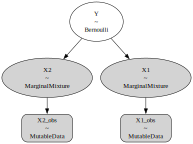

In [8]:
import pymc as pm; from pymc import Model

p_Y = y_train.mean()
mu_1_0 = X_train[ (y_train == 0), 0].mean(); mu_1_1 = X_train[ (y_train == 1), 0].mean(); 
mu_2_0 = X_train[ (y_train == 0), 1].mean(); mu_2_1 = X_train[ (y_train == 1), 1].mean(); 
sigma_1_0 = X_train[ (y_train == 0), 0].std(); sigma_1_1 = X_train[ (y_train == 1), 0].std(); 
sigma_2_0 = X_train[ (y_train == 0), 1].std(); sigma_2_1 = X_train[ (y_train == 1), 1].std(); 

with Model() as my_model:  
    X1_obs = pm.Data( "X1_obs", 0,mutable=True)
    X2_obs = pm.Data( "X2_obs", 0,mutable=True)
    Y = pm.Bernoulli("Y", p = p_Y ) 
    X1 = pm.NormalMixture("X1",w = [ 1-Y , Y ], mu = [ mu_1_0, mu_1_1], sigma = [ sigma_1_0, sigma_1_1 ],
                          observed = X1_obs )
    X2 = pm.NormalMixture("X2", w = [ 1-Y , Y ] ,mu = [ mu_2_0, mu_2_1], sigma = [ sigma_2_0, sigma_2_1 ],
                          observed = X2_obs )

# import graphviz; import matplotlib as plt
graph = pm.model_to_graphviz(my_model);graph.graph_attr.update(size='8,2');graph    

### 2.2.2. Probabilistic Model MAP Predictions
We can use this probabilistic model for classification. For Naive Bayes, the predicted class is the maximum-a-posteriori (MAP) estimate for $Y$ given the features $X_1,X_2$. 
Because $Y$ is categorical, we will optimize the posterior by comparing all possible values, and picking the value of $Y$ giving the highest posterior likelihood.

The following code sets the observed feature values to be the first instance in the test set, then calculates the (posterior) log-likelihood for both $Y=0$ and $Y=1$, and then picks the $Y$ value that gives the highest log-likelihood (i.e., the MAP estimate for $Y$ for these features).

In [9]:
### example: MAP prediction for 1 test data

# Set observed values for features 
my_model.set_data("X1_obs", X_test[0,0]);my_model.set_data("X2_obs", X_test[0,1]) 

# Compile model likelihood for observed data 
log_likelihood = my_model.compile_logp() 
print("loglikelihood of Y=0 is" ,log_likelihood({'Y': 0 })); print("loglikelihood of Y=1 is", log_likelihood({'Y': 1 }) )

# Calculate MAP prediction for Y
MAP = (log_likelihood({'Y': 0 }) < log_likelihood({'Y':1}))*1.0 
print( "MAP prediction for 1st test data:", MAP )

loglikelihood of Y=0 is 0.009042451690249198
loglikelihood of Y=1 is 1.9724690504735132
MAP prediction for 1st test data: 1.0


Create a for loop to run this process over all data on the test set, and store your MAP predictions in an array. 
Compare the out-of-sample predictions you got from `sklearn.naive_bayes.GaussianNB()` to the ones from this PGM with `pymc`; they should be identical.

In [10]:
### MAP predictions for all test data
y_pred_PGM = []
for i in range( X_test.shape[0] ):
    my_model.set_data("X1_obs", X_test[i,0]) # set observed values for features 
    my_model.set_data("X2_obs", X_test[i,1])
    log_likelihood = my_model.compile_logp() # compile model likelihood for observed data 
    y_pred_PGM.append( (log_likelihood({'Y': 0 }) < log_likelihood({'Y':1}))*1.0 ) 

np.array( y_pred_PGM ) == y_pred_GNB   

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])